## Imports and Notebook Configuration

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn

In [2]:
# Set notebook plotting parameters.
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (12, 8),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

## Summary

This notebook explores the topic of statistical modeling for daily fantasy football.  There are a few websites (DraftKings, FanDuel) that offer real money if you're able to predict which players in sports will perform well in any given game, or week.  I've been pretty passionate about fantasy football over the past decade, but I've never deeply explored the data and this notebook aims to address that void.

Before we start, for any data modeling problem, there are 2 important questions to reflect on:
1. Is this problem even worth working on?  Time is valuable; I need to make sure I'm using my time effectively.
2. Where do I get quality data for this problem?

The answers to the above questions are that:
1. I am both intrinsically and extrinsically motivated to solve this problem; intrinsic in that I've always been curious about football stats, and extrinsic in that if I can shed some light on this problem, I can make some money (unlikely, but still a fun thought to entertain).
2. A model is only as good as the data that is fed into it.  There's a lot of football data on the web, but a lot of it is deeply embedded in web pages and it's hard to find useful csvs or APIs that are free to use.  After some digging, I found some historic DraftKings data to work with, but I needed to scrape it off of a bunch of web pages.  I also found an API that has information about every play that has ever happened in the NFL data, so I pulled some of that data as well to inform any models built here.  Other data which could be useful would be weather conditions for each game, or perhaps even running sentiment analysis of players on fantasy football forums. 

In this notebook, I'll be working with DraftKings data.  I found some historic DraftKings data on the web, and have cleaned it up a bit so it's easier to work with (see parse_draftkings_historic_data.py).

The main problem that I try to solve in this notebook is getting an accurate prediction of the amount of points a player will score in a week, given past football data that I've harvested from the web.

## DraftKings Historic Data

How DraftKings NFL works is that you play the role of a manager of a fantasy football team.  Each week, you are given 50k virtual dollars to allocate to build a team of 1 QB, 2 RBs, 3 WRs, a DEF, a K, and a FLEX position.  You need to allocate this money wisely to build a team that will score the most points possible.  Let's look at some historic DraftKings data below.

In [3]:
dk_data = pd.read_csv('./data/draftkings/draftkings_data.csv', header=None, names=['week','year','id','player','position','team','game','opponent','points','salary'])

In [4]:
dk_data.head(3)

,week,year,id,player,position,team,game,opponent,points,salary
0,2,2017,1131,Brady Tom,QB,nwe,a,nor,33.78,7900
1,2,2017,1514,Wentz Carson,QB,phi,a,kan,28.82,5900
2,2,2017,1151,Brees Drew,QB,nor,h,nwe,25.24,7700


In [391]:
dk_data.shape

(13584, 12)

Each row represents a player playing a game in a given week, their salary, the points they ended up scoring that week, as well as some additional details about the player such as their team, position, opponent, etc.  Let's start by brainstorming some questions that will need to be answered in order to build a model to make money off of fantasy football.

## Brainstorming Questions
1. **(Modeling)** What's the relationship between DraftKings salary and points, overall, and by position? 

    - The thought here is that we can exploit any trendlines in the data.  If the relationship between salaries and points is totally linear with a y-intercept of 0, then it doesn't matter how you allocate your budget.  Having a team totally comprised of midrange players would on average perform equally as well as a team of mostly duds with one or two all-stars.


2. **(Modeling)** How do we build a model that is better than a **salary-only model** (a model that uses only Draft Kings salary data to predict points)?

    - If we can build such a model that better predicts the points than using salaries alone, that doesn't necessarily mean it will be a winning model; at the end of the day, the model needs to be able to beat > 56% of humans on a weekly basis.  However, building a model that's better than the salary-only model **would** indicate that we've found factors that are useful to incorporate into our selection of players that perhaps DraftKings isn't accounting for.  By identifying factors in this way it gives us better intuition for the game, and if we have a more accurate model, we should be able to identify **bargain players** defined as players where our model predicts a higher point total than the salary-only model.


3. **(Feature Engineering)** We **could** manually engineer a bunch of features that we think would be useful in predicting points, but it would be nice to automatically engineer features.  What features might be useful?

    - Weather.
    - Recent performance.
    - Targets over the past few weeks.
    - How good is the opposing defense?  How to get this data?
    - Home vs. Away status.  Do some players perform better home or on the road?  This seems like a possibility.
    - Are some players more likely to be "bounce-back" players?  E.g. If a player performs poorly one week, are they more likely to score more than their mean amount of points the next week?  Even finding something like this could give our model an edge.
    - Player traits:  Is this player "supposed" to be good?  Examples:
        - Were they a high draft pick?
        - Have they been in the league 10 years and always produced at a high level?
        - What does their career trajectory look like?  Are they on a long-term upswing or downswing?  This is perhaps a more interesting question to answer for full season long fantasy football formats.  Recent performance is likely more important in the current exercise. 
        - How tall is the player?
        - How much does the player weigh?
        - What were their combine stats like (e.g. how fast did they run the 40 yard dash or 3 cone drill?)
    - Where does the player lie in the depth chart at their position?  If a player is number 1 on the depth chart at their position, they should be more likely to produce higher points.


4. **(Model Selection / Evaluation)** We need to be careful to divide our data up properly into training, validation, and test sets, or adopt a rigorous cross-validation scheme, so that we aren't cheating by training on the test data.  Once you've used the test data, you can't go back and retrain your model.


5. **(Game Theory)** Could we look at our opponents' teams and build a roster that is more likely to win, knowing who is on their team?  E.g. If your opponent selects Tyreek Hill, you could pick Patrick Mahomes to offset the chance that Tyreek Hill wins the week for your opponent.  What are the best strategies here?


6. **(Dimension Reduction)** What players are most similar to each other across all our features?


7. **(Strategy)** Is it better to pick players with high or low variance?  Figure out which players are the most consistent and most variable.

## How Does Salary Relate to Points?

If there's a linear relationship, then it's equally valuable to target players along the salary curve.  If, however, there's some nonlinear relationship then perhaps it's better to construct a team that consists mostly of mid-range players, or perhaps a team with a few top dogs, and the rest, bottom-feeders.

Plot a quick scatter plot to explore the relationship.

In [5]:
x = dk_data.salary
y = dk_data.points

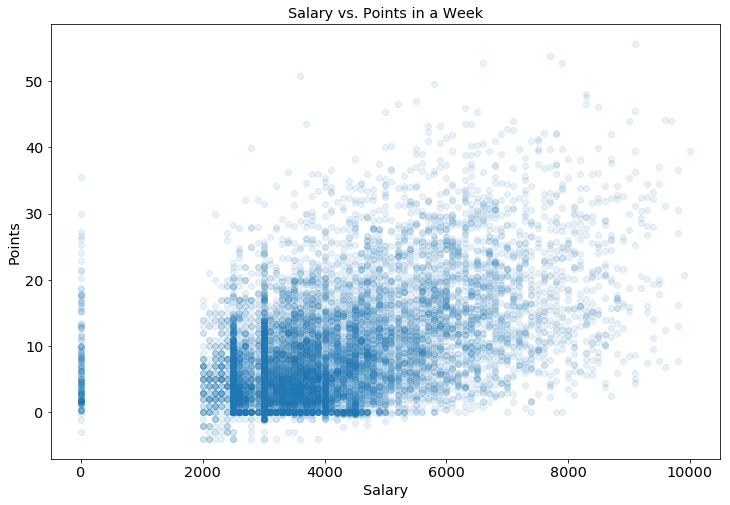

In [6]:
fig = plt.figure(figsize=(12,8));
plt.scatter(x, y, alpha=0.1);
plt.title('Salary vs. Points in a Week');
plt.xlabel('Salary');
plt.ylabel('Points');

Why are there many players with salary=0?  What's going on here?  It's also interesting to see that there seem to be more players clustered at salaries with round numbers, like 3000, 2500, and 4000.  

In [7]:
dk_data[dk_data.salary == 0].head(10)

,week,year,id,player,position,team,game,opponent,points,salary
88,2,2017,2645,Johnson Chris,RB,ari,a,ind,4.40,0
95,2,2017,5450,Collins Alex,RB,bal,h,cle,3.20,0
164,2,2017,5475,Higgins Rashard,WR,cle,a,bal,16.90,0
226,2,2017,5577,Gentry Tanner,WR,chi,a,tam,4.70,0
656,14,2017,5607,Powe Darius,WR,nyg,h,dal,3.30,0
885,16,2018,1536,Allen Kyle,QB,car,h,atl,1.52,0
896,16,2018,2924,Anderson C.J.,RB,lar,a,ari,26.20,0
1280,17,2018,1409,Luck Andrew,QB,ind,a,ten,24.10,0
1296,17,2018,1381,Gabbert Blaine,QB,ten,h,ind,8.60,0
1306,17,2018,1446,Gilbert Garrett,QB,car,a,nor,1.60,0


Notice how there can be huge bargains with salary=0 (Andrew Luck, CJ Anderson).  It might be possible to take advantage of this fact when picking players.

If we plot the mean and standard deviation of points by salary range, what do we see then?

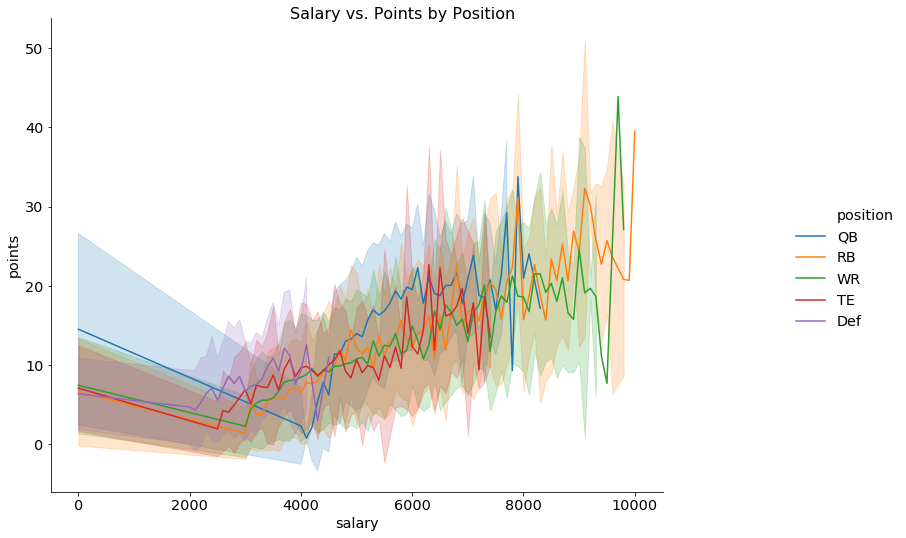

In [8]:
g = sns.relplot(x='salary', y='points', hue='position', kind='line', ci='sd', data=dk_data);
g.fig.set_size_inches(14,8);
g.fig.suptitle('Salary vs. Points by Position', size=16);

From the above figure it appears that investing in a quality QB sees diminishing returns past a salary of 6k-ish, characterized by a steep increase in value from 4k to 6k and flattening out at 6k.  The other positions, by contrast, show a fairly linear increasing amount of points per unit increase in salary.  It also seems like it may be worth investing in really expensive running backs.

Looking below at a linear regression relating salary to points, we see that approximately 60% of the variance in points is explained by using salary alone (R-squared value).  But I'm sure we can do better!

In [9]:
import statsmodels.api as sm
sm.OLS(endog=dk_data.salary, exog=dk_data.points).fit().summary()

y = dk_data.salary
X = dk_data.points
sm.add_constant(X)
model = sm.OLS(y, X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 salary   R-squared (uncentered):                   0.596
Model:                            OLS   Adj. R-squared (uncentered):              0.596
Method:                 Least Squares   F-statistic:                          2.005e+04
Date:                Tue, 03 Sep 2019   Prob (F-statistic):                        0.00
Time:                        14:23:46   Log-Likelihood:                     -1.2629e+05
No. Observations:               13584   AIC:                                  2.526e+05
Df Residuals:                   13583   BIC:                                  2.526e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
points       290.6977      2.053    141.615      0.000     286.674     294.721
==============================================================================
Omnibus:                     2949.729   Durbin-Watson:                   0.442
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6912.282
Skew:                          -1.221   Prob(JB):                         0.00
Kurtosis:                       5.501   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Data Cleaning and Feature Engineering

### Cleaning the nflgame Data

Let's try getting some more useful features to build a better model.  There's an API called nflgame that helps us get data about every play that has ever happened in the NFL (let's call this the **play-level data**) as well as aggregated data about players for every game they have ever played (let's call this the **game-level data**).  I've included the nflgame package as a git submodule in this repo.  Let's explore what kind of raw data is offered by this API.  I've already got the raw game-level data for each week, but now I need to clean it so it can be combined with the DraftKings data.

In [244]:
nflgame_df = pd.DataFrame()

weeks = [i+1 for i in range(17)]
years = [2017, 2018]
for y in years:
    for w in weeks:
        if y == 2018 and w == 4:
            pass
        else:
            nflgame_temp_df = pd.read_csv('./data/nflgame/game-level-raw/{year}-{week}-game-level-data.csv'.format(week=w, year=y), na_values=0)
            nflgame_temp_df['week'] = w
            nflgame_temp_df['year'] = y
            nflgame_df = pd.concat([nflgame_df, nflgame_temp_df])


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  del sys.path[0]


In [245]:
nflgame_data = nflgame_df.fillna(0)
# Get rid of any players with null positions.
nflgame_data['pos'] = nflgame_data['pos'].replace(0, 'NA')

In [246]:
# Reduce column set to only ones we are interested in.  Let's eliminate all of the defensive stats, kicking stats, and two point conversion stats.
columns = ['home', 'id', 'name', 'team', 'week', 'year', 'passing_att', 'passing_cmp', 'passing_cmp_air_yds', 'passing_first_down', 'passing_incmp', 'passing_incmp_air_yds', 'passing_int', 'passing_sk', 'passing_sk_yds', 'passing_tds', 'passing_yds', 'pos', 'receiving_rec', 'receiving_tar', 'receiving_tds', 'receiving_yac_yds', 'receiving_yds', 'rushing_att', 'rushing_first_down', 'rushing_loss', 'rushing_tds', 'rushing_yds']

In [247]:
nflgame_data = nflgame_data[columns]

In [251]:
from pandas.api.types import is_string_dtype

def str_cols_to_upper(df):
    cols = df.columns.tolist()
    for c in cols:
        if is_string_dtype(df[c]):
            df[c] = df[c].apply(lambda x: x.upper())
    return df

In [252]:
nflgame_data = str_cols_to_upper(nflgame_data)

In [253]:
nflgame_data.info()
nflgame_data.head(2)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32294 entries, 0 to 1039
Data columns (total 28 columns):
home                     32294 non-null object
id                       32294 non-null object
name                     32294 non-null object
team                     32294 non-null object
week                     32294 non-null int64
year                     32294 non-null int64
passing_att              32294 non-null float64
passing_cmp              32294 non-null float64
passing_cmp_air_yds      32294 non-null float64
passing_first_down       32294 non-null float64
passing_incmp            32294 non-null float64
passing_incmp_air_yds    32294 non-null float64
passing_int              32294 non-null float64
passing_sk               32294 non-null float64
passing_sk_yds           32294 non-null float64
passing_tds              32294 non-null float64
passing_yds              32294 non-null float64
pos                      32294 non-null object
receiving_rec            32294 non-nu

,home,id,name,team,week,year,passing_att,passing_cmp,passing_cmp_air_yds,passing_first_down,...,receiving_rec,receiving_tar,receiving_tds,receiving_yac_yds,receiving_yds,rushing_att,rushing_first_down,rushing_loss,rushing_tds,rushing_yds
0,NO,00-0031203,C.SANTOS,KC,1,2017,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,NO,00-0030155,D.HARRIS,KC,1,2017,0.0,0.0,0.0,0.0,...,2.0,2.0,1.0,4.0,15.0,0.0,0.0,0.0,0.0,0.0


We've successfully read in the data from the nflgame API for years 2017-2018 and weeks 1-17.  There are a few more things we need to do.  Player names are formatted a bit differently in the DraftKings data than the nflgame data, so we need to unify the naming convention here.  DraftKings labels its players `<lastname> <firstname>` whereas nflgame labels its players `<firstinitial>.<lastname>`.  Note also that with nflgame's naming convention, it is very possible for two players to have the same name.  For example, in the past there have been multiple Brandon Marshalls in the league, a wide receiver, and a linebacker.  Therefore, when joining the datasets, we likely need to join on all of firstinitial, lastname, week, year, team, and position.  We'll need to be careful that players who play multiple positions are considered the same position in both nflgame and DraftKings, and we'll also need to inspect that the team is correct for players who have switched teams in a year.

Some data cleaning issues here included that nflgame sometimes labeled players with `<firstfewinitials>.<lastname>`, not simply their first initial, and another issue is that some last names include periods, such as St. Brown, or Johnson Jr., etc.  I've also seen some spaces added after the first period; in other words, the name data can be pretty messy.

In [254]:
nflgame_data['firstinitial'] = nflgame_data['name'].apply(lambda s: s.split('.')[0][0])

In [255]:
def get_last_name(s):
    a = s.split('.')
    b = a.pop(0)
    return ' '.join(a)

nflgame_data['lastname'] = nflgame_data['name'].apply(get_last_name)

In [154]:
# This highlighted some of the data quality issues while cleaning the dataset.
# nflgame_data.loc[nflgame_data['name'].str.contains(r'(\w)+\.$')][['name','team','week','year']]

### Cleaning the DraftKings Data

Let's clean up the DraftKings name data now.

In [273]:
dk_data['firstinitial'] = dk_data['player'].apply(lambda x: x.split(' ')[-1][0])

In [257]:
# This doesn't work for the defense data.
dk_data['lastname'] = dk_data['player'].apply(lambda x: ' '.join(x.split(' ')[0:-1]))

### Team Name Inconsistencies

Another inconsistency is that the way team names are formatted is not the same between nflgame and DraftKings.  For example, New England is represented as NWE in DraftKings (I know, what a monstrosity) but is given the label NE in nflgame.  Let's map the DraftKings team names to the nicer labels.

In [266]:
dk_data_set = set(dk_data['team'])
nflgame_data_set = set(nflgame_data['team'])

In [269]:
print('Teams in DraftKings data not in nflgame:')
print(dk_data_set.difference(nflgame_data_set))
print('Teams in nflgame not in DraftKings data:')
print(nflgame_data_set.difference(dk_data_set))

Teams in DraftKings data not in nflgame:
{'NWE', 'NOR', 'LAR', 'TAM', 'KAN', 'GNB', 'SFO', 'JAC'}
Teams in nflgame not in DraftKings data:
{'TB', 'LA', 'NO', 'JAX', 'KC', 'SF', 'NE', 'GB'}


In [270]:
team_name_map = {
    'NWE': 'NE',
    'NOR': 'NO',
    'LAR': 'LA',
    'TAM': 'TB',
    'KAN': 'KC',
    'GNB': 'GB',
    'SFO': 'SF',
    'JAC': 'JAX'
}

In [272]:
dk_data = dk_data.replace({'team': team_name_map, 'opponent': team_name_map})

### Combining the Data

In [275]:
combined_data = pd.merge(left=dk_data, right=nflgame_data, how='inner', on=['firstinitial', 'lastname', 'week', 'year', 'team'])

In [280]:
combined_data.head(1)

,week,year,id_x,player,position,team,game,opponent,points,salary,...,receiving_rec,receiving_tar,receiving_tds,receiving_yac_yds,receiving_yds,rushing_att,rushing_first_down,rushing_loss,rushing_tds,rushing_yds
0,2,2017,1131,BRADY TOM,QB,NE,A,NO,33.78,7900,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,9.0


### Create Some Simple Features

As a simple start, let's try using the last 3 games' worth of production to try to predict the current game's points. For each of the feature columns (pass yds, receiving yds, etc.), let's create another feature called receiving_yds_x where x ranges from 1 to 3 to indicate that it is the receiving yards from 1, 2, 3 games ago.  This is of course going to create some correlation between the feature columns, but it's at least a good start.

In [323]:
feature_cols_to_transform = ['passing_att', 'passing_cmp', 'passing_cmp_air_yds', 'passing_first_down', 'passing_incmp', 'passing_incmp_air_yds', 'passing_int', 'passing_sk', 'passing_sk_yds', 'passing_tds', 'passing_yds', 'receiving_rec', 'receiving_tar', 'receiving_tds', 'receiving_yac_yds', 'receiving_yds', 'rushing_att', 'rushing_first_down', 'rushing_loss', 'rushing_tds', 'rushing_yds']

In [289]:
combined_data.sort_values(by=['player', 'position', 'team', 'year', 'week'], inplace=True)

In [332]:
data = combined_data.copy()
# data.set_index(['player', 'position', 'year', 'week', 'team'])

for i in range(3):
    for c in feature_cols_to_transform:
        # .shift returns all NaNs, likely because it's operating on the index.  
        data[c+'_'+str(i+1)] = data.groupby(['player', 'position', 'team'])[c].shift(i+1)

feature_data = data

In [325]:
feature_data.head()

,week,year,id_x,player,position,team,game,opponent,points,salary,...,receiving_rec_3,receiving_tar_3,receiving_tds_3,receiving_yac_yds_3,receiving_yds_3,rushing_att_3,rushing_first_down_3,rushing_loss_3,rushing_tds_3,rushing_yds_3
2257,3,2017,5350,ABBREDERIS JARED,WR,DET,H,ATL,0.0,3000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2602,4,2017,5350,ABBREDERIS JARED,WR,DET,A,MIN,0.0,3000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5258,5,2017,5350,ABBREDERIS JARED,WR,DET,H,CAR,5.7,3000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6211,6,2017,5350,ABBREDERIS JARED,WR,DET,A,NO,1.7,3000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
64,2,2017,2995,ABDULLAH AMEER,RB,DET,A,NYG,8.6,4100,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [320]:
# Here's another way of performing the SQL lag function.
# from pandasql import sqldf
# pysqldf = lambda q: sqldf(q, globals())

# print(pysqldf('select week, year, player, position, team, receiving_yds, lag(receiving_yds, 1) over (partition by player, position, team order by year, week) from combined_data')).head()

### Train Test Split, Model Imports, Data Prep for Modeling

In [453]:
# Less than ideal to drop players who don't have data for the past 3 weeks, but for initial baseline modeling efforts I want to keep it as simple as possible.
feature_data_no_nan = feature_data.dropna()

In [504]:
# Will use the same seed for each model below.
from sklearn.model_selection import train_test_split

# Model imports.
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor

# Model evaluation.
from sklearn.metrics import r2_score

In [514]:
def train_and_evaluate_model(X, y, model_type):
    # Train test split.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99)
    
    # Choose model type and fit it.
    if model_type == 'linear':
        model = linear_model.LinearRegression()
    elif model_type == 'random_forest':
        model = RandomForestRegressor(n_estimators=100, random_state=0)
    model.fit(X=X_train, y=y_train)
    
    # Report R^2 scores.
    y_train_pred = model.predict(X_train)
    print('Train R^2 Score: ' + str(r2_score(y_train, y_train_pred)))
    y_test_pred = model.predict(X_test)
    print('Test R^2 Score: ' + str(r2_score(y_test, y_test_pred)))
    
    # Plot the relationship.
    fig = plt.figure(figsize=(12,8));
    plt.scatter(y_test, y_test_pred, alpha=0.2);
    plt.title('Y vs Y Pred (Test Set)');
    plt.xlabel('Y');
    plt.ylabel('Y Pred');

In [530]:
# Data preparation.  Can't use data from current week to predict current week's points.  We might want to keep the player name as a dummy variable later.
data = feature_data_no_nan.drop(columns=feature_cols_to_transform)
data = data.drop(columns=['pos', 'name', 'game', 'firstinitial', 'lastname', 'id_x', 'id_y', 'player'])

### Basic Linear Model (Game Data Only)

Let's try building a model using only the historic game stats features.

In [531]:
X = data.filter(regex=("_+")).values
y = data['points'].values

Train R^2 Score: 0.3632974001891136
Test R^2 Score: 0.3310514930959554


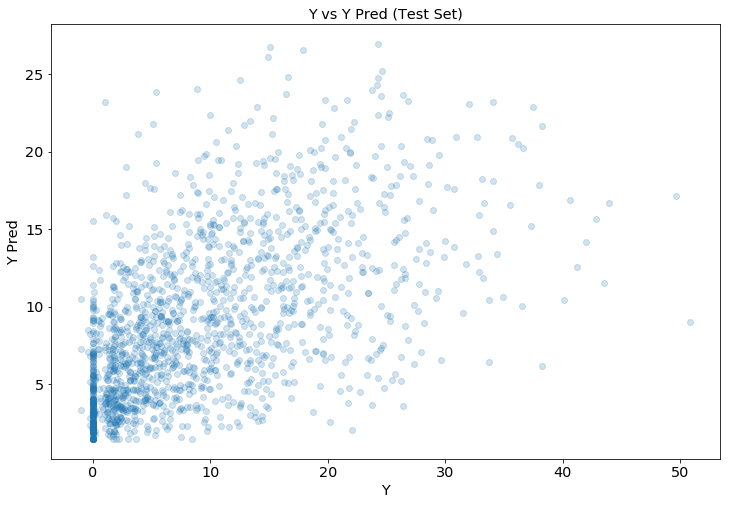

In [532]:
train_and_evaluate_model(X, y, model_type='linear')

Only 33% of the variance is explained with a multiple linear regression model that looks at the past 3 weeks of receiving, passing, and rushing data.  Let's try a model again below that uses salary only to predict points.

### Salary-Only Model

In [534]:
X = data[['salary']].values
y = data['points'].values

Train R^2 Score: 0.3338848432891359
Test R^2 Score: 0.32181136653720777


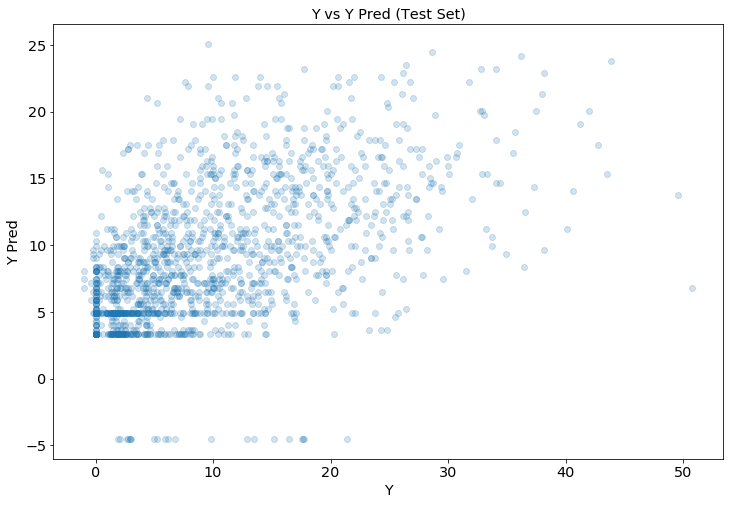

In [535]:
train_and_evaluate_model(X, y, model_type='linear')

Again 33% of the variance is explained using the salaries alone.  It seems that if you only use the salaries, then the model predicts a bunch of players at -5 points, which is odd.  It's kind of cool that a linear model using the past 3 weeks of data can perform roughly as well as the salary-only model, but we can definitely do better.

Let's try a more complicated model of a random forest regression model on each of the salary-only and game-only data.

### Random Forest Regression Model (Game Data Only)

In [538]:
X = data.filter(regex=("_+"))
y = data['points'].values

Train R^2 Score: 0.9015360141527597
Test R^2 Score: 0.3020749868043


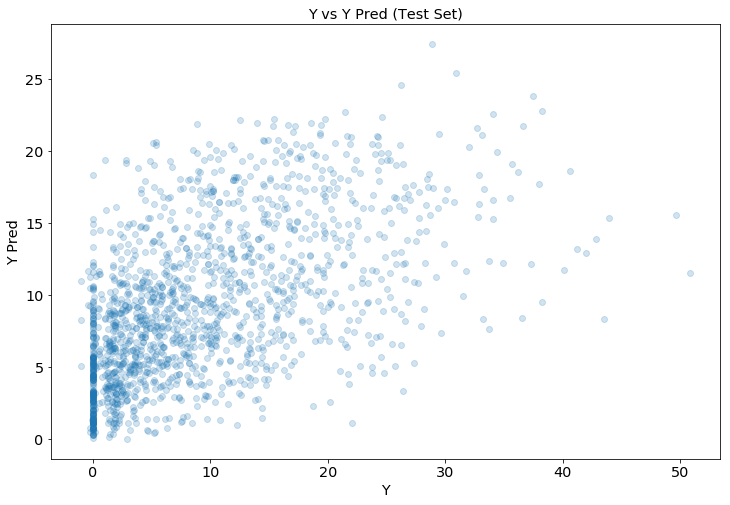

In [539]:
train_and_evaluate_model(X, y, model_type='random_forest')

Huge amount of overfitting and we perform worse on the test set than the basic linear models above.  We need to figure out why and play around with cross-validation a bit to vary the number of trees, size of the trees, etc.  Maybe there just really isn't that much signal in only the past 3 weeks of aggregate data for a player.

In [525]:
# # Feature importance.
# from tabulate import tabulate
# headers = ['name', 'score']
# values = sorted(zip(X.columns, reg.feature_importances_), key=lambda x: x[1] * -1)
# print(tabulate(values, headers, tablefmt="plain"))

### Random Forest Regression Model (Salary Data Only)

In [540]:
X = data[['salary']].values
y = data['points'].values

Train R^2 Score: 0.3855463548623811
Test R^2 Score: 0.36392273235435746


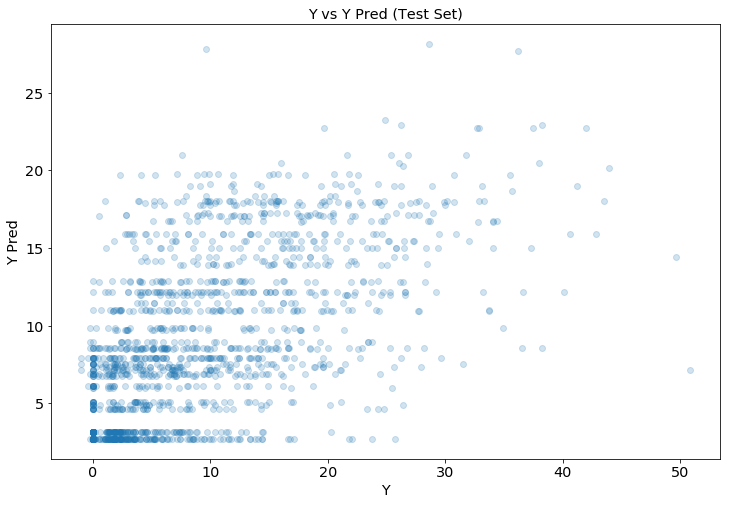

In [541]:
train_and_evaluate_model(X, y, model_type='random_forest')

The best model so far, using a random forest with the salary data only.

### More Complex Modeling Efforts

In [ ]:
X = data.filter(regex=("_+")).values
y = data['points'].values

In order to prepare our data for a basic linear regression model, we need to transform our categorical columns into dummy variables.  These columns include position, team, opponent, and home.  

In [350]:
# Categorical features
categorical_feature_mask = data.dtypes==object
categorical_cols = data.columns[categorical_feature_mask].tolist()

In [351]:
X = data[categorical_cols]

In [355]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

si_step = ('si', SimpleImputer(strategy='constant', fill_value='MISSING'))
ohe_step = ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))
steps = [si_step, ohe_step]
pipe = Pipeline(steps)

X_transform = pipe.fit_transform(X)
X_transform.shape

(10463, 70)

In [356]:
ohe = pipe.named_steps['ohe']
ohe.get_feature_names()

array(['x0_QB', 'x0_RB', 'x0_TE', 'x0_WR', 'x1_ARI', 'x1_ATL', 'x1_BAL',
       'x1_BUF', 'x1_CAR', 'x1_CHI', 'x1_CIN', 'x1_CLE', 'x1_DAL',
       'x1_DEN', 'x1_DET', 'x1_GB', 'x1_HOU', 'x1_IND', 'x1_JAX', 'x1_KC',
       'x1_LA', 'x1_LAC', 'x1_MIA', 'x1_MIN', 'x1_NE', 'x1_NO', 'x1_NYG',
       'x1_NYJ', 'x1_OAK', 'x1_PHI', 'x1_PIT', 'x1_SEA', 'x1_SF', 'x1_TB',
       'x1_TEN', 'x1_WAS', 'x2_ARI', 'x2_ATL', 'x2_BAL', 'x2_BUF',
       'x2_CAR', 'x2_CHI', 'x2_CIN', 'x2_CLE', 'x2_DAL', 'x2_DEN',
       'x2_DET', 'x2_GB', 'x2_HOU', 'x2_IND', 'x2_JAX', 'x2_KC', 'x2_LA',
       'x2_LAC', 'x2_MIA', 'x2_MIN', 'x2_NE', 'x2_NO', 'x2_NYG', 'x2_NYJ',
       'x2_OAK', 'x2_PHI', 'x2_PIT', 'x2_SEA', 'x2_SF', 'x2_TB', 'x2_TEN',
       'x2_WAS', 'x3_NO', 'x3_YES'], dtype=object)

In [357]:
# # Outdated method for one hot encoding.
# from sklearn.preprocessing import OneHotEncoder
# ohe = OneHotEncoder(categorical_features=categorical_feature_mask, sparse=False)
# labelencoded_data_ohe = ohe.fit_transform(labelencoded_data[])

One cool technique here might be to generate a bunch of feature columns like this, then apply some automated feature reduction technique to find things like the min, max, standard deviation of receiving yards, etc. that a player achieved over the past X games.

## Assumptions of Exercise

It's a good practice in a data analysis to make intelligent assumptions to surpass obstacles, but in the case where you don't feel you can make a strong assumption but still need to, it's important to feel not blocked by this and instead try different things and list out your assumptions.  In this section I've listed out assumptions made in this exercise.

Assumptions:
- I dropped all rows with NA values.  This is probably not a good idea because it ignores players with not that much data.  Not the worst thing to do, but there are better ways of dealing with these things.
- I ignored K and DEF categories for now to keep things simple.

## Evaluation

After evaluating any models that I've built, I plan on testing them with real money, against other opponents, and against my own custom built team without any model input.  As a rough estimate, I'm thinking of investing 100 dollars, and building 5, 2 dollar teams each week for 10 weeks.  This will give me 40 data points of model-built teams to evaluate the model.  I plan on providing a more rigorous estimate with a power calculation of sorts to determine how many games I need to enter in order to be confident that my model performs well or poorly.

## References